In [1]:
import numpy as np
import os
import sys
sys.path.append(".../SWAN_projects/AWAKE_eBeam_Visualization/")
import AEmit
import re
import glob
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from multiprocessing import Pool
from matplotlib.colors import LogNorm
import seaborn as sns
#%matplotlib notebook

# Using emittance provided by ASTRA

In [2]:
os.chdir(".../condor/AWAKE/cathod_x_y_scan/")
all_files = glob.glob("awake_tws_x_*_y_*.Xemit.001")
len(all_files)

948

In [3]:
# parallel, combine all .001 files into a big data frame
def build_list(path):
    r_final_particles = "awake_tws_x_(.\...)_y_(.\...).Xemit*?"
    coords = re.match(r_final_particles, path)
    temp_Xemit = pd.read_csv(path,\
                                header=None,\
                                names=AEmit.df_Xemit_header,\
                                delim_whitespace=True\
                            )
    temp_Xemit["x_off"] = coords[1]
    temp_Xemit["y_off"] = coords[2]
    temp_Yemit = pd.read_csv(path.replace("Xemit", "Yemit"),\
                                header=None,\
                                names=AEmit.df_Yemit_header,\
                                delim_whitespace=True
                            )
    temp_Yemit["x_off"] = coords[1]
    temp_Yemit["y_off"] = coords[2]
    return (temp_Xemit,temp_Yemit)
p = Pool(8)
combined_df = p.map(build_list, all_files);

In [4]:
df_Xemit = pd.concat([df[0] for df in combined_df])
df_Yemit = pd.concat([df[1] for df in combined_df])

In [5]:
df_Xemit_BTV = df_Xemit[df_Xemit["z"]==4.3210]
df_Xemit_BTV.head()

z       t      xavr    xrms  x_prime_rms  e_norm   e_trace x_off  \
478  4.321  14.468  0.042798  1.4211     0.041195  2.0053 -0.013672  0.00   
478  4.321  14.468  0.371800  1.4209     0.041317  2.0102 -0.013752  0.00   
478  4.321  14.468  0.681410  1.4205     0.041563  2.0209 -0.013874  0.00   
478  4.321  14.468  1.010300  1.4199     0.041947  2.0379 -0.014053  0.00   
478  4.321  14.468  1.339100  1.4192     0.042463  2.0605 -0.014298  0.00   

    y_off  
478  0.00  
478  0.17  
478  0.33  
478  0.50  
478  0.67

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev3python3/Sun/x86_64-centos7-gcc7-opt/lib/python3.6/site-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


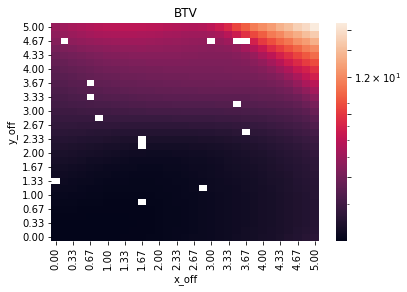

In [6]:
ax = sns.heatmap(df_Xemit_BTV.pivot(index='y_off', columns='x_off', values='e_norm'), norm=LogNorm(df_Xemit_BTV['e_norm'].min(), df_Xemit_BTV['e_norm'].min()))
ax.invert_yaxis()
plt.title("BTV");

# Manual emittance calculation

## Beam emittence scan for off set on cathod
This is where the initial distribution of the electrons from cathod is given an offset in the x-y plane, withiin 5mm

In [7]:
os.chdir(".../condor/AWAKE/cathod_x_y_scan/")
Cathod_files = glob.glob("awake_tws_x_*_y_*.0432.001")
Cathod_files[600:610]
# matches = list(map(lambda x: re.match("awake_tws_x_(.\...)_y_(.\...).0432.001", x), Cathod_files))
# x_y_coords = [(x[1], x[2]) for x in matches]

['awake_tws_x_3.17_y_3.50.0432.001',
 'awake_tws_x_3.17_y_3.67.0432.001',
 'awake_tws_x_3.17_y_3.83.0432.001',
 'awake_tws_x_3.17_y_4.00.0432.001',
 'awake_tws_x_3.17_y_4.17.0432.001',
 'awake_tws_x_3.17_y_4.33.0432.001',
 'awake_tws_x_3.17_y_4.50.0432.001',
 'awake_tws_x_3.17_y_4.67.0432.001',
 'awake_tws_x_3.17_y_4.83.0432.001',
 'awake_tws_x_3.17_y_5.00.0432.001']

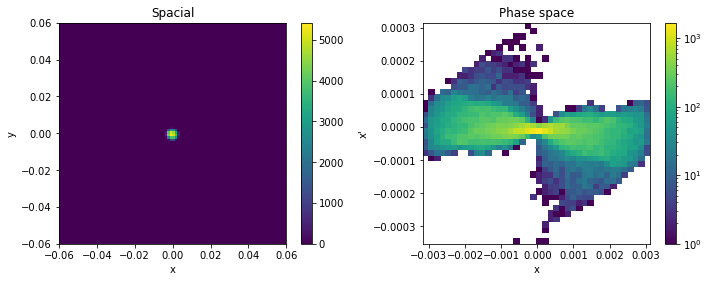

In [8]:
plt_sample = AEmit.particle_df('awake_tws_x_0.17_y_0.00.0432.001')
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
AEmit.particle_plot(plt_sample)
plt.subplot(1, 2, 2)
AEmit.phase_plot(plt_sample)
plt.tight_layout(pad=1)

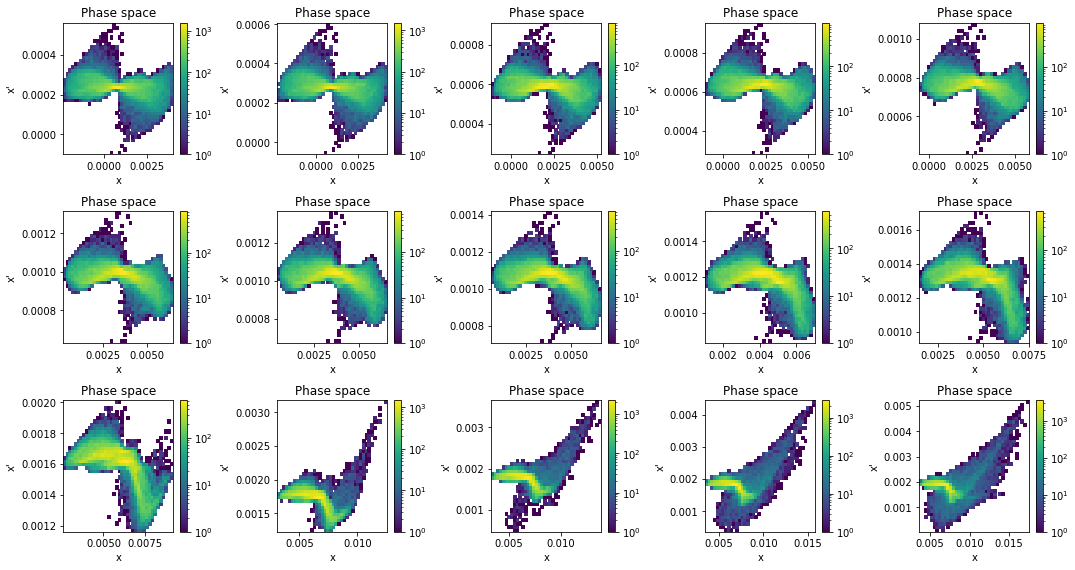

In [9]:
AEmit.scan_phase(Cathod_files)

In [10]:
[np.mean(AEmit.particle_df(x)["pz"]) / 10**6 for x in Cathod_files[:10]] # energy of bunch in MeV

[18.555541155530925,
 18.555119096092167,
 18.55574728820434,
 18.555320586762008,
 18.55593361803465,
 18.55583244851151,
 18.555432774431345,
 18.556033975468143,
 18.555361565720226,
 18.55604655901006]

In [11]:
# parallel, combine all .001 files into a big data frame
def get_nemittance(path):
    coords = re.match("awake_tws_x_(.\...)_y_(.\...)\.0432\.001", path)
    x_off, y_off = coords[1], coords[2]
    sample_df = pd.read_csv(path,\
                            header=None,\
                            names=AEmit.df_particles_header,\
                            delim_whitespace=True\
                        )
    ref = sample_df.iloc[0, :]
    sample_df= sample_df.iloc[1:, :]
    sample_df["pz"] += ref["pz"]
    sample_df["x_prime"] = sample_df["px"] / np.mean(sample_df["pz"])
    return pd.DataFrame.from_dict({'x_off': [x_off], 'y_off': [y_off], 'nemittance':[AEmit.norm_emittance(sample_df)]})

In [12]:
p = Pool(8)
df_cathod = pd.concat(p.map(get_nemittance, Cathod_files))

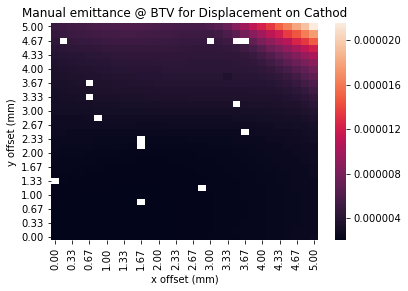

In [13]:
ax = sns.heatmap(df_cathod.pivot(index='y_off', columns='x_off', values='nemittance'))
ax.invert_yaxis()
plt.title("Manual emittance @ BTV for Displacement on Cathod")
plt.xlabel("x offset (mm)")
plt.ylabel("y offset (mm)");

# Camparison of Spacecharge on and off in cathod displacemtn

In [14]:
os.chdir(".../condor/AWAKE/quick_cathod_x_y_scan/")
quick_cathod_files = glob.glob("awake_tws_x_*_y_*.0432.001")
quick_cathod_files[600:610]

['awake_tws_x_3.17_y_1.83.0432.001',
 'awake_tws_x_3.17_y_2.00.0432.001',
 'awake_tws_x_3.17_y_2.17.0432.001',
 'awake_tws_x_3.17_y_2.33.0432.001',
 'awake_tws_x_3.17_y_2.50.0432.001',
 'awake_tws_x_3.17_y_2.67.0432.001',
 'awake_tws_x_3.17_y_2.83.0432.001',
 'awake_tws_x_3.17_y_3.00.0432.001',
 'awake_tws_x_3.17_y_3.17.0432.001',
 'awake_tws_x_3.17_y_3.33.0432.001']

In [15]:
[np.mean(AEmit.particle_df(x)["pz"]) / 10**6 for x in quick_cathod_files[:3]]

[5.798625414443496, 5.798625476638589, 5.798625529876211]

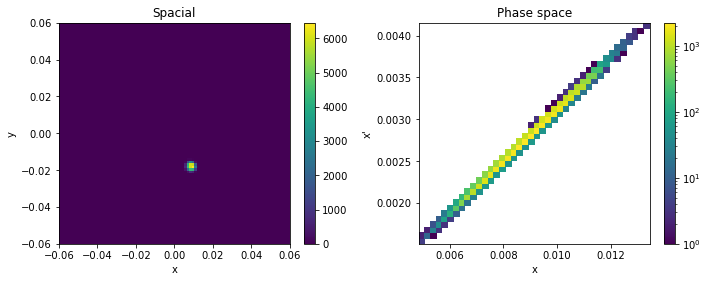

In [16]:
plt_sample = AEmit.particle_df("awake_tws_x_3.17_y_2.83.0432.001")
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
AEmit.particle_plot(plt_sample)
plt.subplot(1, 2, 2)
AEmit.phase_plot(plt_sample)
plt.tight_layout(pad=1)

In [17]:
p = Pool(8)
df_quick_cathod = pd.concat(p.map(get_nemittance, quick_cathod_files))

Text(0.5, 1, 'Manual emittance @ BTV for Displacement on Cathod')

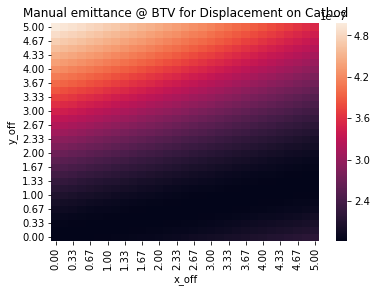

In [18]:
ax = sns.heatmap(df_quick_cathod.pivot(index='y_off', columns='x_off', values='nemittance'))
ax.invert_yaxis()
plt.title("Manual emittance @ BTV for Displacement on Cathod")
#plt.xlabel("x offset (mm)")
#plt.ylabel("y offset (mm)");

## Beam emittence scan for tws boost cavity displacement

This is where the rest of the beam line is untouched, but the traveling wave boosting cavity is given a displacement in x-y plane

In [19]:
os.chdir(".../condor/AWAKE/tws_x_y_scan/")
tws_files = glob.glob("awake_tws_x_*_y_*.0432.001")
tws_files[33]
# matches = list(map(lambda x: re.match("awake_tws_x_(.\...)_y_(.\...).0432.001", x), Cathod_files))
# x_y_coords = [(x[1], x[2]) for x in matches]

'awake_tws_x_0.17e-3_y_1.00e-3.0432.001'

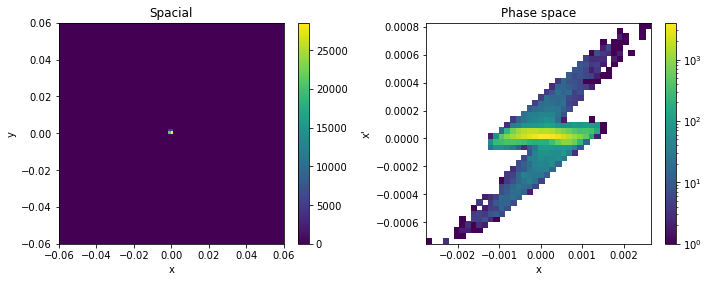

In [20]:
plt_sample = AEmit.particle_df('awake_tws_x_0.00e-3_y_0.83e-3.0432.001')
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
AEmit.particle_plot(plt_sample)
plt.subplot(1, 2, 2)
AEmit.phase_plot(plt_sample)
plt.tight_layout(pad=1)

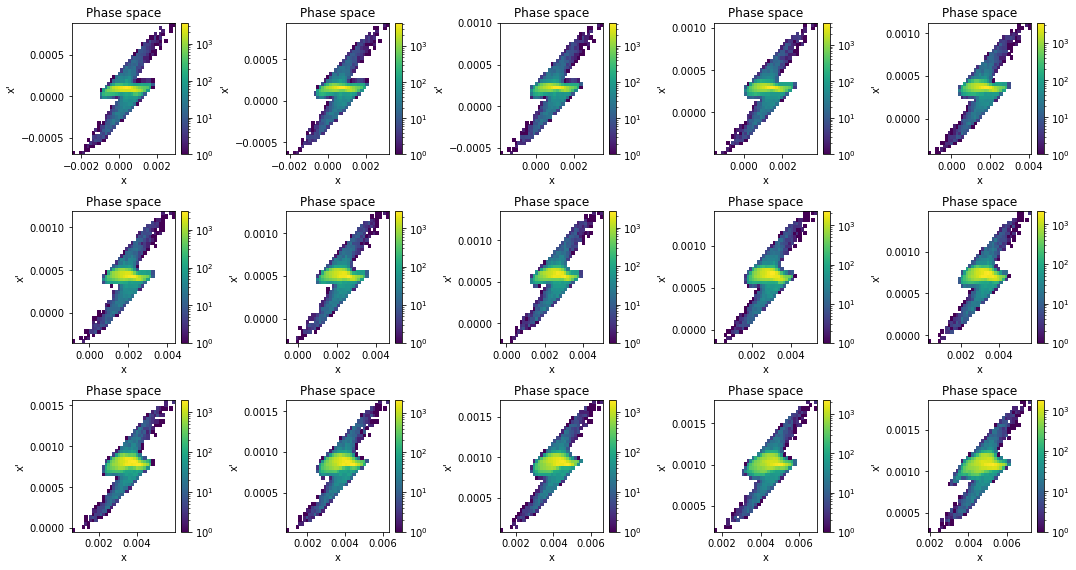

In [21]:
AEmit.scan_phase(tws_files)

In [22]:
[np.mean(AEmit.particle_df(x)["pz"]) / 10**6 for x in tws_files[:3]]

[18.552811996040422, 18.552815159048173, 18.5528532694431]

In [23]:
# parallel, combine all .001 files into a big data frame
# ffs, here the cavity displacement is given in SI unit
def get_nemittance(path):
    coords = re.match("awake_tws_x_(.*?)_y_(.*?)\.0432\.001", path)
    x_off, y_off = coords[1], coords[2]
    try:
        sample_df = pd.read_csv(path, header=None, names=AEmit.df_particles_header, delim_whitespace=True)
    except:
        res_df = pd.DataFrame()
        res_df["x_off"] = [np.float(x_off)*1000]
        res_df["y_off"] = [np.float(y_off)*1000]
        res_df['nemittance'] = [np.nan]
        return res_df
    ref = sample_df.iloc[0, :]
    sample_df= sample_df.iloc[1:, :]
    sample_df["pz"] += ref["pz"]
    sample_df["x_prime"] = sample_df["px"] / np.mean(sample_df["pz"])
    res_df = pd.DataFrame()
    res_df["x_off"] = [np.float(x_off)*1000]
    res_df["y_off"] = [np.float(y_off)*1000]
    res_df['nemittance'] = [AEmit.norm_emittance(sample_df)]
    return res_df
    #return pd.DataFrame.from_dict({'x_off': [float(x_off)*10], 'y_off': [float(y_off)*10], 'nemittance':[AEmit.norm_emittance(sample_df)]})

In [24]:
p = Pool(8)
df_tws = pd.concat(p.map(get_nemittance, tws_files[:520]))

Text(0.5, 1, 'Displacement of cavity')

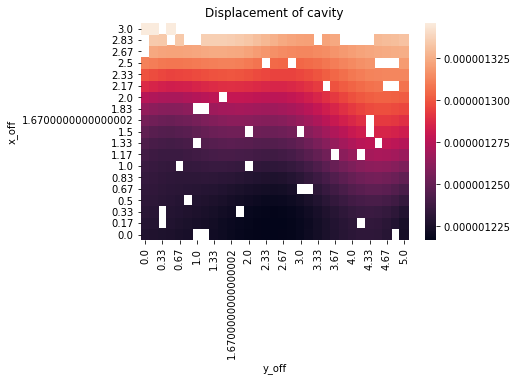

In [25]:
ax=sns.heatmap(df_tws.pivot_table(index='x_off', columns='y_off', values='nemittance'))
ax.invert_yaxis()
#plt.plot(df_tws["y_off"], df_tws["nemittance"], 'bx')
plt.title("Displacement of cavity")
#plt.xlabel("x offset (mm)")
#plt.ylabel("y offset (mm)");

## Beam emittence scan for solenoid stregth

In [26]:
def build_particles(path):
    B_pattern = 'awake_tws_MaxB_(.\....).*?'
    BMax = re.match(B_pattern, path)[1]
    sample_df = pd.read_csv(path,\
                            header=None,\
                            names=AEmit.df_particles_header,\
                            delim_whitespace=True\
                        )
    ref = sample_df.iloc[0, :]
    sample_df= sample_df.iloc[1:, :]
    sample_df["pz"] += ref["pz"]
    sample_df["x_prime"] = sample_df["px"] / np.mean(sample_df["pz"])
    sample_df["BMax"] = float(BMax)
    return sample_df

In [27]:
os.chdir(".../condor/AWAKE/MaxB_scan/")
all_Bfiles = glob.glob("awake_tws_MaxB_*.0432.001")
print(len(all_Bfiles))
all_Bfiles[:10]

54


['awake_tws_MaxB_0.245.0432.001',
 'awake_tws_MaxB_0.246.0432.001',
 'awake_tws_MaxB_0.247.0432.001',
 'awake_tws_MaxB_0.248.0432.001',
 'awake_tws_MaxB_0.249.0432.001',
 'awake_tws_MaxB_0.251.0432.001',
 'awake_tws_MaxB_0.252.0432.001',
 'awake_tws_MaxB_0.253.0432.001',
 'awake_tws_MaxB_0.254.0432.001',
 'awake_tws_MaxB_0.255.0432.001']

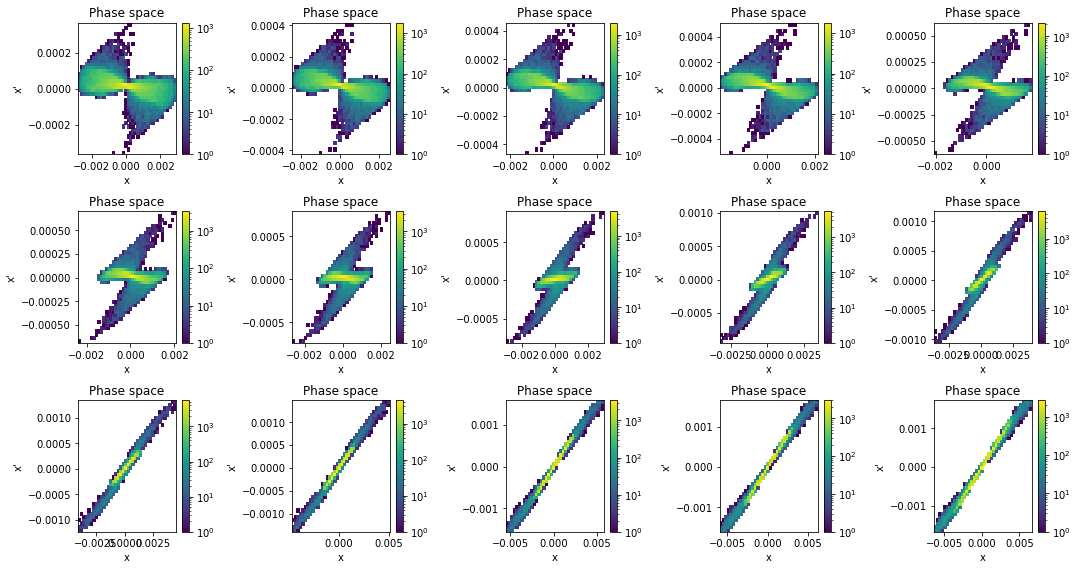

In [28]:
AEmit.scan_phase(all_Bfiles)

In [29]:
p = Pool(8)
combined_Bdf = pd.concat(p.map(build_particles, all_Bfiles));

In [30]:
BMax_lst = list(set(combined_Bdf["BMax"]))
norm_emit_lst = [AEmit.norm_emittance(combined_Bdf[combined_Bdf["BMax"] == x]) for x in BMax_lst]

Text(0, 0.5, 'normalized_emittance')

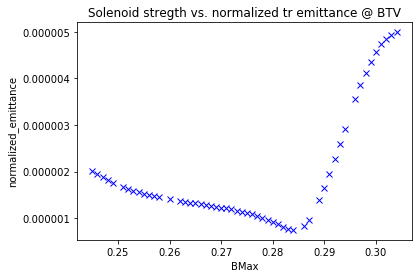

In [31]:
plt.plot(BMax_lst, norm_emit_lst, 'bx')
plt.title("Solenoid stregth vs. normalized tr emittance @ BTV")
plt.xlabel("BMax")
plt.ylabel("normalized_emittance")